In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

st_shp = Path("Resources/Map Files/brfss_state_2010_download.shp")

data = gpd.read_file(st_shp, index=False)

In [2]:
data.columns

Index(['STATE_NAME', 'SUB_REGION', 'STATE_ABBR', 'ST_FIPS', 'year', 'state',
       'A187_1', 'A187_2', 'A187_3', 'A187_4',
       ...
       'A5021_2', 'A6606_1', 'A6606_2', 'A6607_1', 'A6607_2', 'A6610_1',
       'A6610_2', 'A7307_1', 'A7307_2', 'geometry'],
      dtype='object', length=117)

In [3]:
print(data.crs)

data = data.to_crs(epsg=4326)


PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102039"]]


In [4]:
print(data.geometry.head())

0    MULTIPOLYGON (((-111.97980 24.87260, -111.9651...
1    MULTIPOLYGON (((-117.39424 29.30275, -117.2868...
2    MULTIPOLYGON (((-117.03205 48.99993, -117.0291...
3    POLYGON ((-104.06299 49.00003, -104.05232 48.6...
4    MULTIPOLYGON (((-70.81867 43.12187, -70.83055 ...
Name: geometry, dtype: geometry


<Axes: >

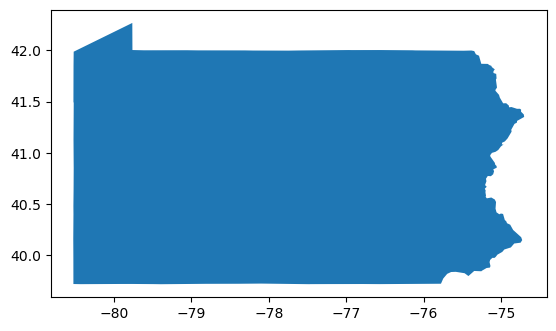

In [5]:
%matplotlib inline
data.loc[data['STATE_ABBR']=='PA'].plot()

In [6]:
from shapely.geometry import Point, Polygon

fc_api_geo_csv = Path("Resources/Map files/fc_api_geo_df.csv")

fc_api_geo_df = pd.read_csv(fc_api_geo_csv)

fc_api_geo_df['geolocation']

0        ('32.84057112200048', '-86.63186076199969')
1        ('32.84057112200048', '-86.63186076199969')
2        ('32.84057112200048', '-86.63186076199969')
3        ('32.84057112200048', '-86.63186076199969')
4        ('32.84057112200048', '-86.63186076199969')
                            ...                     
93244             ('43.235541343', '-108.109830353')
93245             ('43.235541343', '-108.109830353')
93246             ('43.235541343', '-108.109830353')
93247             ('43.235541343', '-108.109830353')
93248             ('43.235541343', '-108.109830353')
Name: geolocation, Length: 93249, dtype: object

In [7]:
# This ought to be done in the first_clean notebook, when tuple was addressed
def convert_to_float_tuple(str_tuple):
    # Strip off the parentheses and split by comma
    clean_str = str_tuple.strip('()')
    str_items = clean_str.split(', ')
    # Convert split strings to float
    return tuple(float(item.strip("'")) for item in str_items[::-1]) # [::-1] reverse the order of the coordinates

fc_api_geo_df['geolocation_tuple'] = fc_api_geo_df['geolocation'].apply(convert_to_float_tuple)

# Print the updated DataFrame
print(fc_api_geo_df['geolocation_tuple'])

0        (-86.63186076199969, 32.84057112200048)
1        (-86.63186076199969, 32.84057112200048)
2        (-86.63186076199969, 32.84057112200048)
3        (-86.63186076199969, 32.84057112200048)
4        (-86.63186076199969, 32.84057112200048)
                          ...                   
93244             (-108.109830353, 43.235541343)
93245             (-108.109830353, 43.235541343)
93246             (-108.109830353, 43.235541343)
93247             (-108.109830353, 43.235541343)
93248             (-108.109830353, 43.235541343)
Name: geolocation_tuple, Length: 93249, dtype: object


In [8]:
test_cords = fc_api_geo_df['geolocation_tuple'].iloc[3]
test_cords

(-86.63186076199969, 32.84057112200048)

In [9]:
p1 = Point(test_cords)
poly_test_1 = data.loc[data['STATE_ABBR'] == 'AL', 'geometry']
print(p1)
print(poly_test_1)

POINT (-86.63186076199969 32.84057112200048)
43    POLYGON ((-85.00161 31.00125, -85.48501 31.001...
Name: geometry, dtype: geometry


In [10]:
p1.within(poly_test_1)


43    True
Name: geometry, dtype: bool

In [11]:
## Should have removed these way earlier in fc.ipynb, temp code for testing.
fc_api_geo_df = fc_api_geo_df.dropna(subset=['geolocation_tuple'])
fc_api_geo_df = fc_api_geo_df[fc_api_geo_df['locationabbr'] != "US"]

In [12]:
fc_api_geo_df['geometry'] =  fc_api_geo_df['geolocation_tuple'].apply(lambda x: Point(x[0], x[1]))
fc_gdf = gpd.GeoDataFrame(fc_api_geo_df, geometry='geometry')



In [13]:
fc_gdf = fc_gdf.set_crs(data.crs, allow_override=True)

In [14]:
invalid_geometries = fc_gdf[~fc_gdf.geometry.is_valid]
print(invalid_geometries)

Empty GeoDataFrame
Columns: [yearstart, yearend, locationabbr, locationdesc, datasource, class, topic, question, data_value_type, data_value, data_value_alt, low_confidence_limit, high_confidence_limit, sample_size, age_years, classid, topicid, questionid, datavaluetypeid, locationid, stratificationcategory1, stratification1, stratificationcategoryid1, stratificationid1, education, gender, income, total, race_ethnicity, data_value_footnote_symbol, data_value_footnote, geolocation, geolocation_tuple, geometry]
Index: []

[0 rows x 34 columns]


In [15]:
point_in_states = gpd.sjoin(fc_gdf,data, how="right",op='within')

c:\Users\Hailey\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [16]:
print(point_in_states[['locationabbr', 'geometry', 'STATE_ABBR']])

   locationabbr                                           geometry STATE_ABBR
0           NaN  MULTIPOLYGON (((-111.97980 24.87260, -111.9651...         AK
1           NaN  MULTIPOLYGON (((-117.39424 29.30275, -117.2868...         HI
2            WA  MULTIPOLYGON (((-117.03205 48.99993, -117.0291...         WA
2            WA  MULTIPOLYGON (((-117.03205 48.99993, -117.0291...         WA
2            WA  MULTIPOLYGON (((-117.03205 48.99993, -117.0291...         WA
..          ...                                                ...        ...
50           MI  MULTIPOLYGON (((-89.02862 47.85066, -89.13988 ...         MI
50           MI  MULTIPOLYGON (((-89.02862 47.85066, -89.13988 ...         MI
50           MI  MULTIPOLYGON (((-89.02862 47.85066, -89.13988 ...         MI
50           MI  MULTIPOLYGON (((-89.02862 47.85066, -89.13988 ...         MI
50           MI  MULTIPOLYGON (((-89.02862 47.85066, -89.13988 ...         MI

[84823 rows x 3 columns]


In [17]:
print(point_in_states.columns.tolist())
[point_in_states['index_left']]

['index_left', 'yearstart', 'yearend', 'locationabbr', 'locationdesc', 'datasource', 'class', 'topic', 'question', 'data_value_type', 'data_value', 'data_value_alt', 'low_confidence_limit', 'high_confidence_limit', 'sample_size', 'age_years', 'classid', 'topicid', 'questionid', 'datavaluetypeid', 'locationid', 'stratificationcategory1', 'stratification1', 'stratificationcategoryid1', 'stratificationid1', 'education', 'gender', 'income', 'total', 'race_ethnicity', 'data_value_footnote_symbol', 'data_value_footnote', 'geolocation', 'geolocation_tuple', 'STATE_NAME', 'SUB_REGION', 'STATE_ABBR', 'ST_FIPS', 'year', 'state', 'A187_1', 'A187_2', 'A187_3', 'A187_4', 'A187_5', 'A187_6', 'A559_1', 'A559_2', 'A559_3', 'A559_4', 'A559_5', 'A745_1', 'A745_2', 'A745_3', 'A745_4', 'A745_5', 'A745_6', 'A868_1', 'A868_2', 'A880_1', 'A880_2', 'A1100_1', 'A1100_2', 'A1100_3', 'A1100_4', 'A1100_5', 'A1363_1', 'A1363_2', 'A1363_3', 'A1363_4', 'A1613_1', 'A1613_2', 'A1613_3', 'A1613_4', 'A1613_5', 'A1613_6'

[0         NaN
 1         NaN
 2     63316.0
 2     63315.0
 2     52999.0
        ...   
 50    57976.0
 50    57977.0
 50    57978.0
 50    57979.0
 50    57980.0
 Name: index_left, Length: 84823, dtype: float64]

In [25]:
labels = data['STATE_ABBR']

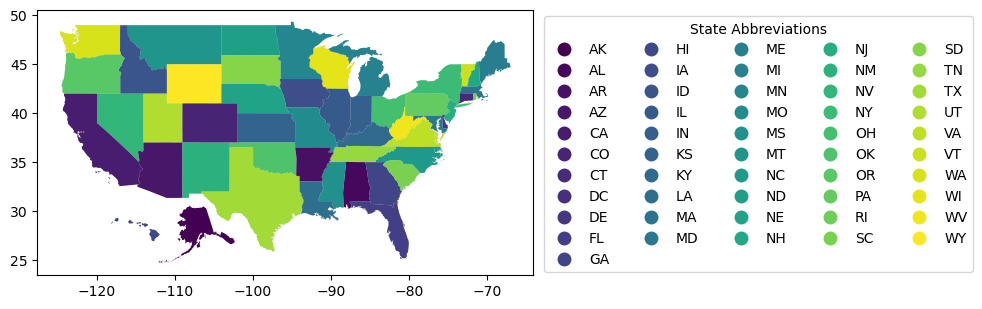

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
data.plot(ax=ax, color='lightgrey')  # Plot all states
scatter = data.plot(ax=ax, column='STATE_ABBR', legend=True, cmap='viridis', 
                               legend_kwds={'title': 'State Abbreviations',
                                            'bbox_to_anchor': (1.9,1),
                                            'ncol': 5,
                                            'loc': 'best'})

plt.show()

In [47]:
point_in_states.to_csv("Resources/Map files/point_to_states.csv")